# Example : entropy calculations

(c) Charles Le Losq and contributors, 2021-2025
see embedded licence file

In this notebook we show how one can use i-Melt to observe how a property like glass transition temperature changes with composition in a systematic way.

We focus on building contour maps of variations in entropy with SiO$_2$, Al$_2$O$_3$, and mixing 2 metal cations.

### Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt 

# import imelt
import imelt

# other essentials
import torch

# we will work on CPU there
device = imelt.get_default_device()
print(device)

CUDA AVAILABLE? 
Yes, setting device to cuda
cuda


### Loading dataset and models

In [2]:
# data are loaded using the data_loader helper.
ds = imelt.data_loader()

# The 10 models are loaded through a bagging class.
neuralmodel = imelt.load_pretrained_bagged()

/home/charles/miniconda3/envs/imelt/lib/python3.11/site-packages/imelt/model.py:1728: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path / name, map_

# Calculate glass transition temperature Tg for a single composition

In [7]:
X_SiO2 = imelt.generate_query_single(sio2=100.0)
prediction_ = neuralmodel.predict(["tg",], X_SiO2)
tg_SiO2 = prediction_["tg"]
print("The glass transition temperature Tg is {:.1f} K".format(tg_SiO2[0]))

The glass transition temperature Tg is 1424.1 K


We can calculate an error bar estimate for this value by querying several samples:

In [9]:
prediction_ = neuralmodel.predict(["tg",], X_SiO2, sampling=True, n_sample=50)
tg_SiO2 = prediction_["tg"]

Here I queried 50 samples from 10 models so I have in total 500 samples, from which I can calculate statistics like the mean and standard deviation:

In [10]:
print("Mean value: {:.1f}".format(np.mean(tg_SiO2)))
print("Standard deviation: {:.1f}".format(np.std(tg_SiO2)))

Mean value: 1415.8
Standard deviation: 59.3


### Visualizing how Tg and fragility changes with composition

Tg and fragility are two parameters important for melt viscosity equations such as MYEGA.

We can use the function `generate_query_range` to follow how they change with melt composition.

Here we range from a simple sodium silicate glass to a complex Ca-Na aluminosilicate one for the sack of example.

We also will plot 100 prediction samples, so we have an idea of the variability associated with the predictions.

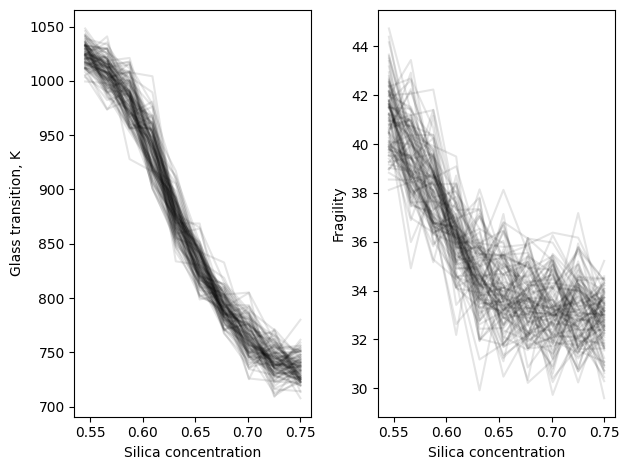

In [14]:
# below we generate compositions
Compo_ = {"sio2": [0.75, 0.60],
         "al2o3": [0.00, 0.20],
         "na2o" : [0.25, 0.10],
           "k2o": [0.00, 0.05],
           "mgo": [0.00, 0.05],
           "cao": [0.00, 0.10]}

X_in = imelt.generate_query_range(Compo_, nb_values=10)
predictions_  = neuralmodel.predict(["tg", "fragility"], X_in.to_numpy(), sampling=True)

plt.figure()
plt.subplot(1,2,1)
plt.plot(X_in.sio2, predictions_["tg"], color="k", alpha=0.1)
plt.xlabel("Silica concentration")
plt.ylabel("Glass transition, K")

plt.subplot(1,2,2)
plt.plot(X_in.sio2, predictions_["fragility"], color="k", alpha=0.1)
plt.xlabel("Silica concentration")
plt.ylabel("Fragility")

plt.tight_layout()

# Generating manually a more complex example

In [15]:

def generate_compo(sio2, R_MAl, cation1="na2o", cation2="k2o"):
    
    # First we check the cations that were selected
    if (cation1 == "na2o") & (cation2 == "k2o"):
        cation3 = "mgo"
        cation4 = "cao"
    elif (cation1 == "na2o") & (cation2 == "mgo"):
        cation3 = "k2o"
        cation4 = "cao"
    elif (cation1 == "na2o") & (cation2 == "cao"):
        cation3 = "k2o"
        cation4 = "mgo"
    elif (cation1 == "k2o") & (cation2 == "mgo"):
        cation3 = "na2o"
        cation4 = "cao"
    elif (cation1 == "k2o") & (cation2 == "cao"):
        cation3 = "na2o"
        cation4 = "mgo"
    elif (cation1 == "mgo") & (cation2 == "cao"):
        cation3 = "na2o"
        cation4 = "k2o"
    
    # generating starting arrays
    xk = np.linspace(0.,1.,500)
    out=np.zeros((len(sio2)*500,7))

    # Generating the initial dataframe
    for i in range(0,len(sio2)):
        out[i*500:(i+1)*500,0] = sio2[i] # first column is sio2
        out[i*500:(i+1)*500,-1] = xk # last column is xk

    master_df = pd.DataFrame(data=out, columns=["sio2","al2o3","na2o","k2o","mgo","cao","xk"])
    master_df.loc[:,'al2o3'] = R_MAl * (1.0 - master_df.loc[:,'sio2'])
    metals = 1.0 - master_df['sio2'] - master_df['al2o3']
    master_df[cation1] = (1.0-master_df.loc[:,"xk"])*metals
    master_df[cation2] = master_df.loc[:,"xk"]*metals
    master_df[cation3] = 0.0
    master_df[cation4] = 0.0

    return master_df




# SiO2 between 50 and 100% (nearly)
sio2_gen = np.arange(0.5,0.999,0.005)

# Na-K mixtures
X_gen_RS_nak_rec = generate_compo(sio2_gen, 0.00, cation1="na2o", cation2="k2o")
X_gen_R3_nak_rec = generate_compo(sio2_gen, 0.25, cation1="na2o", cation2="k2o")
X_gen_R1_nak_rec = generate_compo(sio2_gen, 0.50, cation1="na2o", cation2="k2o")

# Ca-Mg mixtures
X_gen_RS_camg_rec = generate_compo(sio2_gen, 0.00, cation1="mgo", cation2="cao")
X_gen_R3_camg_rec = generate_compo(sio2_gen, 0.25, cation1="mgo", cation2="cao")
X_gen_R1_camg_rec = generate_compo(sio2_gen, 0.50, cation1="mgo", cation2="cao")

### We now calculate the Tg.

We only want one property here. `neuralmodel.predict` provides a dictionary of predictions, which keys are the requested properties. This is the new behavior since i-Melt v2.2.0. When you want to have only predictions for a given property, you can simply query the dictionary key at the end of the function call. This avoids havign to write two lines, as we did above. I will do that below to keep the code short:

In [16]:
sctg_RS_nak_rec  = neuralmodel.predict(["tg",],imelt.descriptors(X_gen_RS_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())["tg"]
sctg_R3_nak_rec  = neuralmodel.predict(["tg",],imelt.descriptors(X_gen_R3_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())["tg"]
sctg_R1_nak_rec  = neuralmodel.predict(["tg",],imelt.descriptors(X_gen_R1_nak_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())["tg"]
sctg_RS_camg_rec = neuralmodel.predict(["tg",],imelt.descriptors(X_gen_RS_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())["tg"]
sctg_R3_camg_rec = neuralmodel.predict(["tg",],imelt.descriptors(X_gen_R3_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())["tg"]
sctg_R1_camg_rec = neuralmodel.predict(["tg",],imelt.descriptors(X_gen_R1_camg_rec.loc[:,["sio2","al2o3","na2o","k2o","mgo","cao"]]).to_numpy())["tg"]

### And we do a figure 

It plots contour maps of the entropy as a function of chemistry.

First line will be Na-K mixtures, second Ca-Mg ones.

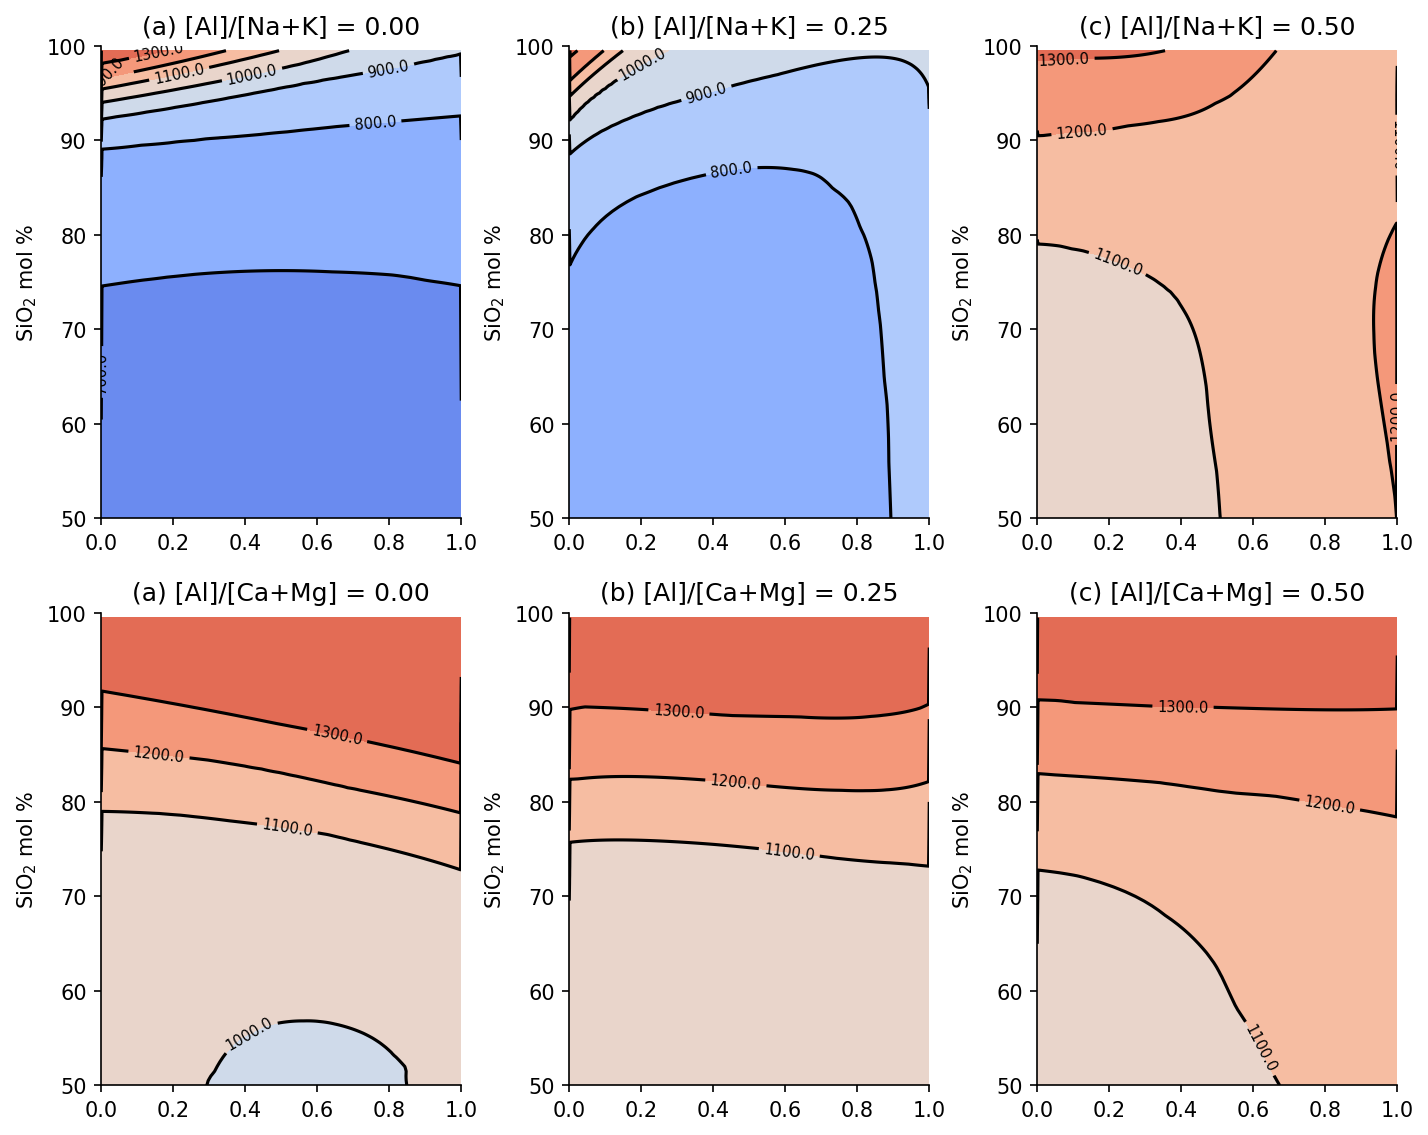

In [17]:
def entro_mix_fig(ax1, X, y, title_string, set_y_label=True,
                  norm = matplotlib.colors.Normalize(vmin=500,vmax=1500.0), # Manual setup
                    c_m = matplotlib.cm.coolwarm, # choose a colormap
                    levels = np.arange(500,1500,100),
                    levels_l = np.arange(500,1500,100)):
    """helper function for the figure"""
    
    s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure
    
    tc1 = ax1.tricontourf(X.loc[:,"xk"], 
                X.loc[:,"sio2"]*100, 
                y, 
                levels=levels, cmap=c_m, norm=norm)
    tc1_l = ax1.tricontour(X.loc[:,"xk"], 
                    X.loc[:,"sio2"]*100, 
                    y, 
                    levels=levels_l, colors='k', norm=norm)
    ax1.clabel(tc1_l, inline=1, fontsize=7, fmt="%1.1f")

    ax1.set_xlim(0,1)
    ax1.set_ylim(50,100.)

    if set_y_label == True:
        ax1.set_ylabel(r"SiO$_2$ mol %")

    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # Title
    ax1.set_title(title_string, loc='center')
    return ax1

#
# Figure generation
#

fig11 = plt.figure(figsize=(9,9), dpi=150, constrained_layout=False)

gs1 = fig11.add_gridspec(nrows=2, ncols=3, 
                        left=0.02, right=0.98,
                        #bottom = 0.55, top = 0.95,
                        wspace=0.3, hspace=0.2)
ax1 = fig11.add_subplot(gs1[0,0])
ax2 = fig11.add_subplot(gs1[0,1])
ax3 = fig11.add_subplot(gs1[0,2])
ax4 = fig11.add_subplot(gs1[1,0])
ax5 = fig11.add_subplot(gs1[1,1])
ax6 = fig11.add_subplot(gs1[1,2])

####
#### XK along near tectosilicate joint
####
ax1 = entro_mix_fig(ax1, X_gen_RS_nak_rec, sctg_RS_nak_rec, "(a) [Al]/[Na+K] = 0.00")
ax2 = entro_mix_fig(ax2, X_gen_R3_nak_rec, sctg_R3_nak_rec, "(b) [Al]/[Na+K] = 0.25")
ax3 = entro_mix_fig(ax3, X_gen_R1_nak_rec, sctg_R1_nak_rec, "(c) [Al]/[Na+K] = 0.50")
ax4 = entro_mix_fig(ax4, X_gen_RS_camg_rec, sctg_RS_camg_rec, "(a) [Al]/[Ca+Mg] = 0.00")
ax5 = entro_mix_fig(ax5, X_gen_R3_camg_rec, sctg_R3_camg_rec, "(b) [Al]/[Ca+Mg] = 0.25")
ax6 = entro_mix_fig(ax6, X_gen_R1_camg_rec, sctg_R1_camg_rec, "(c) [Al]/[Ca+Mg] = 0.50")

plt.show()

### That's it !

This example can be changed as needed, for instance plotting $S^{conf}(T_g)$ or density as a function of composition, or observing other mixtures like Na-Ca or Na-Mg, etc.